# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-02-27 20:31:57.447606: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 20:31:57.475862: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 20:31:57.582260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 20:31:57.582301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 20:31:57.596760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Vanishing/Exploding Gradients Problem

In [2]:
import numpy as np


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

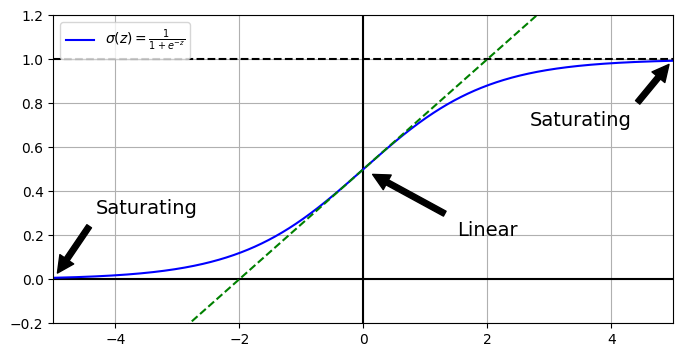

In [3]:
z = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot(z, sigmoid(z), "b-", label=r"$\sigma(z) = \frac{1}{1 + e^{-z}}$")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Saturating",
    xytext=(3.5, 0.7),
    xy=(5, 1),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Saturating",
    xytext=(-3.5, 0.3),
    xy=(-5, 0),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center"
)
plt.grid()
plt.legend(loc="upper left")
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He initialization                

You can switch to your desired initialization by setting the `kernel_initializer` hyperparameter.

In [4]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

If you want to use He initialization with a uniform distribution and based on $fan_{avg}$ instead of $fan_{in}$, you can use the `VarianceScaling` initializer.

In [5]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## Non-saturating Activation Functions

### Leaky ReLU

In [6]:
def leaky_relu(z, alpha):
    return np.maximum(z, alpha * z)

(-5.0, 5.0, -1.0, 4.0)

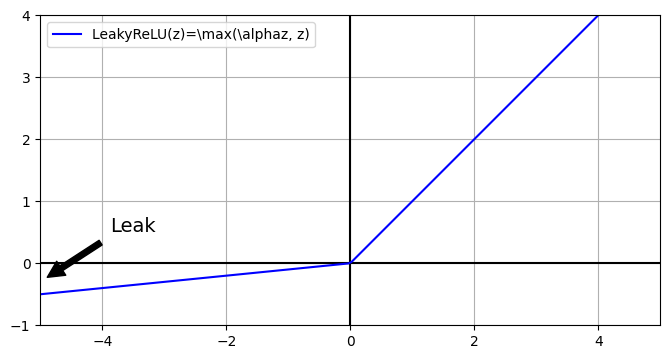

In [7]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=((8, 5)))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, leaky_relu(z, 0.1), "b-", label=r"LeakyReLU(z)=\max(\alphaz, z)")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Leak",
    xy=(-5, -0.3),
    xytext=(-3.5, 0.5),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.gca().set_aspect("equal")
plt.grid()
plt.legend()
plt.axis([-5, 5, -1, 4])

In [8]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

In [9]:
model = tf.keras.Sequential(
    [
        # some layers
        tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
        tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
        # more layers
    ]
)

### ELU and SELU

- We reimplement the SELU using the coefficient in the paper. <br>
- Note that `erfc(x)` function stands for Complementary Error Function, which is defined as `1-rfc(x)`, where `erf(x)` is the Error Function.<br>
- The formula of `erf()` is:
$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}$$
- `erfc(x)` is related to the cumulative distribution function (CDF) of a standard normal distribution:
$$erfc\left(\frac{x}{\sqrt{2}}\right)=2 \times CDF(-x) $$

In [10]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e**2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    )
    ** (-1 / 2)
)


def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)


def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [11]:
scale_0_1

1.0507009873554805

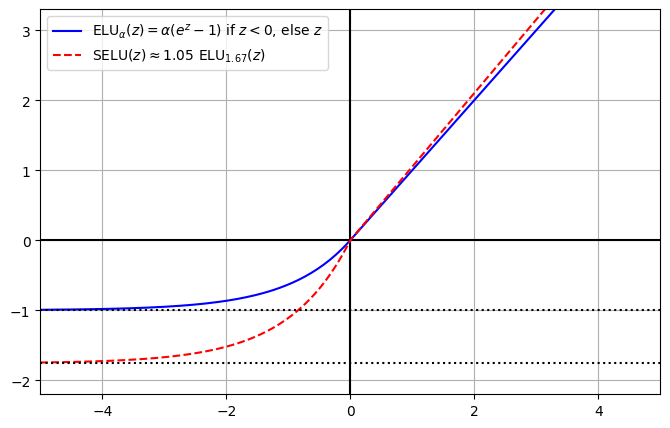

In [12]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8, 5))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, elu(z), "b-", label=r"ELU$_\alpha(z)=\alpha(e^z-1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", label=r"SELU$(z)\approx1.05 \ $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [-1, -1], "k:")
plt.plot([-5, 5], [-scale_0_1 * alpha_0_1, -scale_0_1 * alpha_0_1], "k:")
plt.legend()
plt.grid()
plt.axis([-5, 5, -2.2, 3.3])
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization.

In [15]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

Similarly, using SELU is straightforward.

In [16]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

**Extra material - an example of a self-regularized network using SELU**

Here we create a neural network for Fashion MNIST with 100 hidden layers, using the SELU activation function.

In [17]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now let's train it. Do not forget to scale the input to mean 0 and standard deviation 1.

In [27]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [20]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [26]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.0991 - accuracy: 0.5797 - val_loss: 0.8067 - val_accuracy: 0.7004
Epoch 2/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.8209 - accuracy: 0.6829 - val_loss: 0.6667 - val_accuracy: 0.7444
Epoch 3/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.7469 - accuracy: 0.7032 - val_loss: 0.6544 - val_accuracy: 0.7542
Epoch 4/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.7435 - accuracy: 0.7183 - val_loss: 0.6809 - val_accuracy: 0.7442
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6835 - accuracy: 0.7459 - val_loss: 0.9000 - val_accuracy: 0.6490


The network managed to learn, despite how deep it is. Now look at what happened if we try to use the ReLU activation function instead.

In [32]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

In [34]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 25s 12ms/step - loss: 1.8603 - accuracy: 0.2249 - val_loss: 1.3798 - val_accuracy: 0.4432
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.2928 - accuracy: 0.4329 - val_loss: 0.9994 - val_accuracy: 0.5960
Epoch 3/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.1652 - accuracy: 0.5086 - val_loss: 1.0402 - val_accuracy: 0.5484
Epoch 4/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.9442 - accuracy: 0.6001 - val_loss: 0.8474 - val_accuracy: 0.6672
Epoch 5/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8206 - accuracy: 0.6624 - val_loss: 0.8358 - val_accuracy: 0.6390


Not so great, we suffer from the vanishing/exploding gradients problem.